<a href="https://colab.research.google.com/github/OlajideFemi/Carbon-Footprint/blob/main/Dissertation_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>ARIMA</h1>

In [1]:
#important imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import json
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense




In [2]:
# 1. Data Preparation
import pandas as pd

url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1166194/2005-21-uk-local-authority-ghg-emissions.xlsx'
data_1_1_cleaned = pd.read_excel(url, sheet_name='1_1', skiprows=4)


In [3]:
# Filter the data for the "West Midlands" Region/Country
data_1_1_cleaned = data_1_1_cleaned[data_1_1_cleaned['Region/Country'] == 'West Midlands']
# Filter out rows where "Second Tier Authority" ends with "Total"
data_1_1_cleaned = data_1_1_cleaned[~data_1_1_cleaned['Second Tier Authority'].str.endswith("Total")]

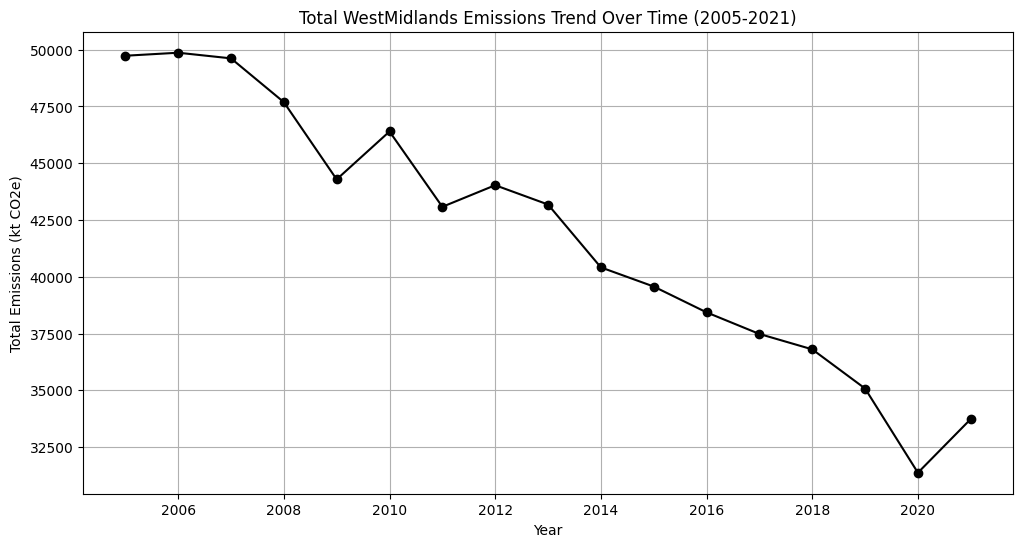

Calendar Year
2005    49732.222417
2006    49865.040184
2007    49616.825647
2008    47689.374420
2009    44287.997799
2010    46396.818960
2011    43080.033683
2012    44031.880064
2013    43181.893928
2014    40413.744458
2015    39570.616279
2016    38433.656517
2017    37482.255734
2018    36805.003905
2019    35080.103036
2020    31372.640144
2021    33736.855308
Name: Grand Total, dtype: float64

In [4]:
import matplotlib.pyplot as plt

# Group by 'Calendar Year' and sum the 'Grand Total' column to get total emissions for each year
yearly_emissions = data_1_1_cleaned.groupby('Calendar Year')['Grand Total'].sum()

yearly_emissions_ = pd.DataFrame(yearly_emissions)

# Plotting the trend over time
plt.figure(figsize=(12, 6))
yearly_emissions.plot(marker='o', linestyle='-', color='black')
plt.title('Total WestMidlands Emissions Trend Over Time (2005-2021)')
plt.xlabel('Year')
plt.ylabel('Total Emissions (kt CO2e)')
plt.grid(True)
plt.show()
yearly_emissions

In [5]:
from statsmodels.tsa.stattools import adfuller

#Augmented Dickey-Fuller test is used to test for the stationarity of a time series
adf_test = adfuller(yearly_emissions_['Grand Total'])
adf_test_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

In [6]:
# Adding critical values
for key, value in adf_test[4].items():
    adf_test_output[f'Critical Value ({key})'] = value

In [7]:
adf_test_output

Test Statistic                  1.644176
p-value                         0.997984
#Lags Used                      6.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64

p-value = 0.997984
Given the p-value is larger than 0.05, it suggest non-stationary data hence an attempt to difference the data

because p-value is greater than 0.05 this indicated that its non-stationary hence differencing is required

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Differencing the data to make it stationary
df_diff = yearly_emissions_['Grand Total'].diff().dropna()

adf_test_diff = adfuller(df_diff)
adf_test_diff_output = pd.Series(adf_test_diff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

adf_test_diff_output

Test Statistic                 -5.102136
p-value                         0.000014
#Lags Used                      1.000000
Number of Observations Used    14.000000
dtype: float64

Now p-value 0.000014 is acceptable.
That suggest (d=1)

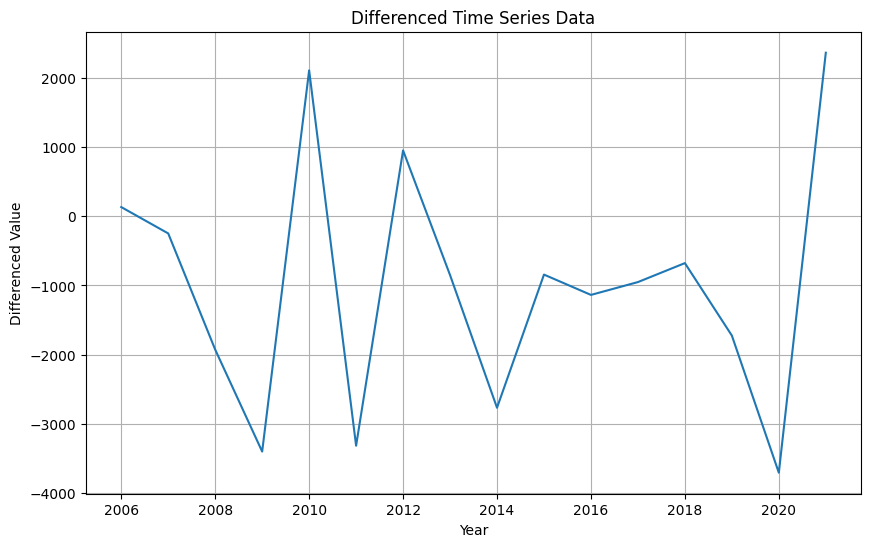

In [9]:
# Plotting the differenced data
plt.figure(figsize=(10, 6))
plt.plot(df_diff)
plt.title('Differenced Time Series Data')
plt.xlabel('Year')
plt.ylabel('Differenced Value')
plt.grid(True)
plt.show()

For the AR and MA(p and q)

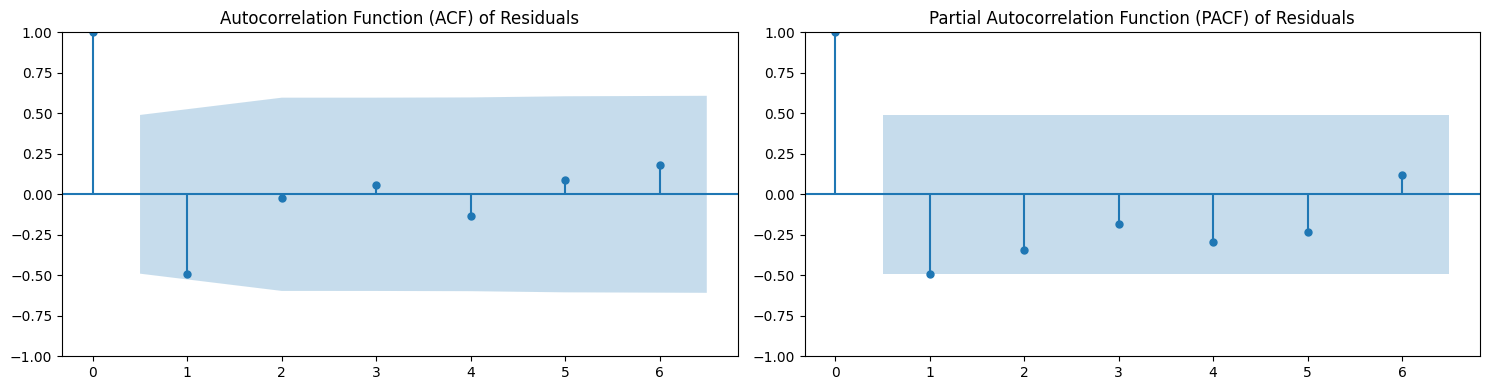

In [10]:
 #ACF and PACF of residuals with fewer lags
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# ACF plot
plot_acf(df_diff, ax=ax[0], lags=6)
ax[0].set_title('Autocorrelation Function (ACF) of Residuals')

# PACF plot
plot_pacf(df_diff, ax=ax[1], lags=6)
ax[1].set_title('Partial Autocorrelation Function (PACF) of Residuals')

plt.tight_layout()
plt.show()


Differencing happen once (d=1), Picking p = 1 and q = 1 from the above plot

In [11]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Filter out the specific warning message
warnings.simplefilter("ignore", category=Warning)


# Fitting the ARIMA model with the determined parameters (p=1, d=1, q=1)
model = ARIMA(yearly_emissions_['Grand Total'], order=(1, 1, 1))
model_fit = model.fit()

# Summarizing the model output
model_summary = model_fit.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Grand Total   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -142.429
Date:                Tue, 06 Feb 2024   AIC                            290.858
Time:                        03:28:36   BIC                            293.175
Sample:                             0   HQIC                           290.976
                                 - 17                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9270      0.047     19.674      0.000       0.835       1.019
ma.L1         -0.9999      0.460     -2.174      0.030      -1.902      -0.098
sigma2      3.132e+06   1.47e-07   2.14e+13      0.000    3.13e+06    3.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.15   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.08   Prob(JB):                         0.79
Heteroskedasticity (H):               1.06   Skew:                             0.15
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.19e+28. Standard errors may be unstable.
"""

In [12]:
# Forecasting future values using the ARIMA(1,1,1) model
forecast_periods = 5  # forecasting for next 5 years

# Forecasting future values
forecast = model_fit.forecast(steps=forecast_periods)
print(forecast)


17    33459.620002
18    33202.613189
19    32964.358894
20    32743.488839
21    32538.734582
Name: predicted_mean, dtype: float64


In [13]:
# iterating over the ARIMA model
fitted_values = model_fit.predict(start=1, end=len(yearly_emissions_['Grand Total']))

# Printing the fitted values
print(fitted_values)


1     48344.756406
2     48521.854537
3     48329.290745
4     46521.264575
5     43296.417748
6     45347.749297
7     42204.603475
8     43140.477064
9     42353.687898
10    39733.880016
11    38947.878181
12    37880.404265
13    36988.257415
14    36355.859160
15    34725.826942
16    31209.360027
17    33459.620002
Name: predicted_mean, dtype: float64


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Actual values from 2006 to 2021
actual_values = [49865.040184, 49616.825647, 47689.374420, 44287.997799, 46396.818960,
                 43080.033683, 44031.880064, 43181.893928, 40413.744458, 39570.616279,
                 38433.656517, 37482.255734, 36805.003905, 35080.103036, 31372.640144,
                 33736.855308]

# Fitted values from your model for the same years
fitted_values = [48344.756378, 48521.854516, 48329.290731, 46521.264576, 43296.417769,
                 45347.749311, 42204.603509, 43140.477094, 42353.687935, 39733.880070,
                 38947.878241, 37880.404331, 36988.257487, 36355.859235, 34725.827027,
                 31209.360134]

mse = mean_squared_error(actual_values, fitted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, fitted_values)
r2 = r2_score(actual_values, fitted_values)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)


MSE: 3156817.9134824006
RMSE: 1776.7436262675606
MAE: 1442.5323537499994
R2 Score: 0.8933601637161586


<h1>LSTM</h1>

In [15]:
# 1. Data Preparation
import pandas as pd

url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1166194/2005-21-uk-local-authority-ghg-emissions.xlsx'
data_1_1_cleaned = pd.read_excel(url, sheet_name='1_1', skiprows=4)

In [16]:
# Filter the data for the "West Midlands" Region/Country
data_1_1_cleaned = data_1_1_cleaned[data_1_1_cleaned['Region/Country'] == 'West Midlands']
# Filter out rows where "Second Tier Authority" ends with "Total"
data_1_1_cleaned = data_1_1_cleaned[~data_1_1_cleaned['Second Tier Authority'].str.endswith("Total")]

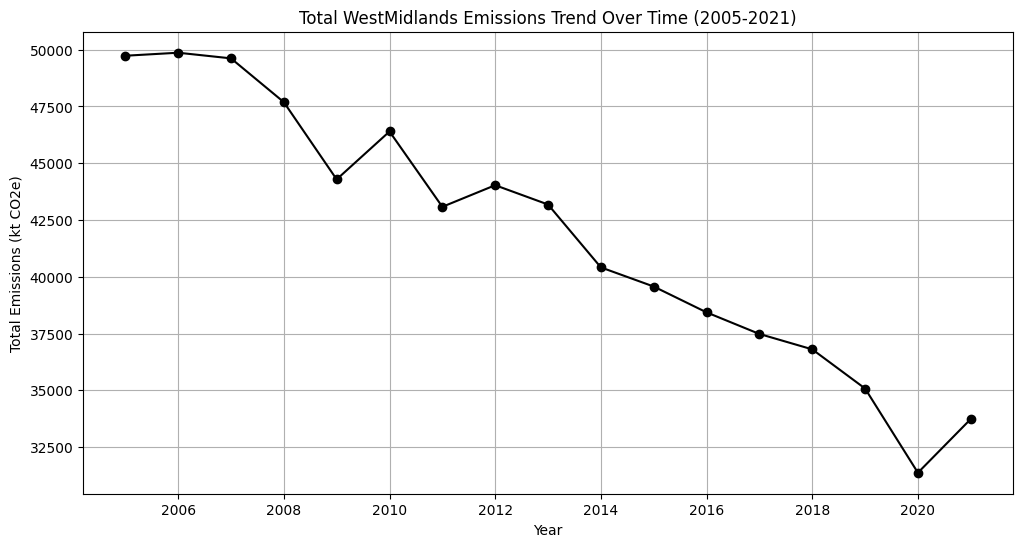

Calendar Year
2005    49732.222417
2006    49865.040184
2007    49616.825647
2008    47689.374420
2009    44287.997799
2010    46396.818960
2011    43080.033683
2012    44031.880064
2013    43181.893928
2014    40413.744458
2015    39570.616279
2016    38433.656517
2017    37482.255734
2018    36805.003905
2019    35080.103036
2020    31372.640144
2021    33736.855308
Name: Grand Total, dtype: float64

In [17]:
import matplotlib.pyplot as plt

# Group by 'Calendar Year' and sum the 'Grand Total' column to get total emissions for each year
yearly_emissions = data_1_1_cleaned.groupby('Calendar Year')['Grand Total'].sum()

yearly_emissions_ = pd.DataFrame(yearly_emissions)

# Plotting the trend over time
plt.figure(figsize=(12, 6))
yearly_emissions.plot(marker='o', linestyle='-', color='black')
plt.title('Total WestMidlands Emissions Trend Over Time (2005-2021)')
plt.xlabel('Year')
plt.ylabel('Total Emissions (kt CO2e)')
plt.grid(True)
plt.show()
yearly_emissions

In [18]:
pip install tensorflow

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Convert the Series to a DataFrame
yearly_emissions_df = yearly_emissions.to_frame()

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_emissions = scaler.fit_transform(yearly_emissions_df)

# Spliting the data into training and testing sets
train_size = int(len(scaled_emissions) * 0.67)
test_size = len(scaled_emissions) - train_size
train, test = scaled_emissions[0:train_size,:], scaled_emissions[train_size:len(scaled_emissions),:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#def create_dataset(dataset, look_back=1):
#    dataX, dataY = [], []
#    for i in range(len(dataset)-look_back):
#        a = dataset[i:(i+look_back), 0]
#        dataX.append(a)
#        dataY.append(dataset[i + look_back, 0])
#    return np.array(dataX), np.array(dataY)

#def create_dataset(dataset, look_back=1):
#    dataX, dataY = [], []
#    for i in range(len(dataset)-look_back):
#        a = dataset[i:(i+look_back), 0]
#        dataX.append(a)
#        dataY.append(dataset[i + look_back])
#    return np.array(dataX), np.array(dataY)



# Reshape the data into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, validation_data=(testX, testY))

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
#trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#testY = scaler.inverse_transform(testY)

#testY = testY.reshape(-1, 1)  # Reshape testY to 2D
#testY = scaler.inverse_transform(testY)

# Calculate root mean squared error
trainScore = np.sqrt(np.mean((trainPredict[:,0] - trainY[0]) ** 2))
testScore = np.sqrt(np.mean((testPredict[:,0] - testY[0]) ** 2))

print('Train Score: %.2f RMSE' % trainScore)
print('Test Score: %.2f RMSE' % testScore)

Epoch 1/100
9/9 - 3s - loss: 0.5520 - val_loss: 0.0493 - 3s/epoch - 326ms/step
Epoch 2/100
9/9 - 0s - loss: 0.5291 - val_loss: 0.0445 - 66ms/epoch - 7ms/step
Epoch 3/100
9/9 - 0s - loss: 0.5066 - val_loss: 0.0401 - 49ms/epoch - 5ms/step
Epoch 4/100
9/9 - 0s - loss: 0.4846 - val_loss: 0.0359 - 64ms/epoch - 7ms/step
Epoch 5/100
9/9 - 0s - loss: 0.4628 - val_loss: 0.0321 - 47ms/epoch - 5ms/step
Epoch 6/100
9/9 - 0s - loss: 0.4410 - val_loss: 0.0287 - 66ms/epoch - 7ms/step
Epoch 7/100
9/9 - 0s - loss: 0.4188 - val_loss: 0.0257 - 63ms/epoch - 7ms/step
Epoch 8/100
9/9 - 0s - loss: 0.3989 - val_loss: 0.0230 - 59ms/epoch - 7ms/step
Epoch 9/100
9/9 - 0s - loss: 0.3781 - val_loss: 0.0206 - 47ms/epoch - 5ms/step
Epoch 10/100
9/9 - 0s - loss: 0.3568 - val_loss: 0.0186 - 63ms/epoch - 7ms/step
Epoch 11/100
9/9 - 0s - loss: 0.3374 - val_loss: 0.0169 - 69ms/epoch - 8ms/step
Epoch 12/100
9/9 - 0s - loss: 0.3182 - val_loss: 0.0157 - 129ms/epoch - 14ms/step
Epoch 13/100
9/9 - 0s - loss: 0.2995 - val_loss

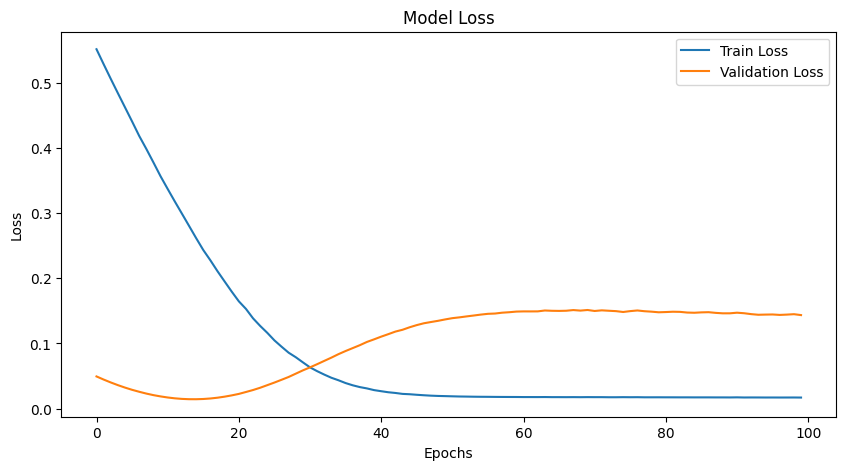

In [20]:
# Plot the training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

<H1>Regression Analysis</H1>



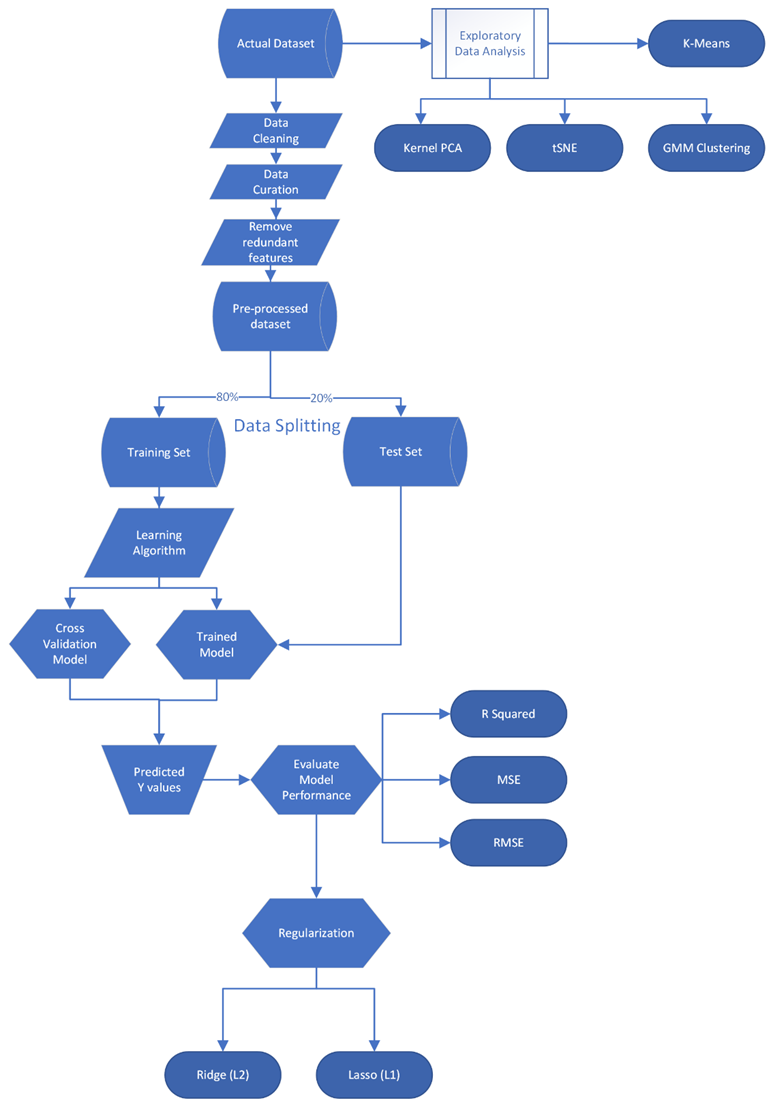

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler




In [22]:
# Load the first few rows from the '1_1' sheet to explore its contents

url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1166194/2005-21-uk-local-authority-ghg-emissions.xlsx'
data_1_1 = pd.read_excel(url, sheet_name='1_1')

#data_1_1 = pd.read_excel("2005-21-uk-local-authority-ghg-emissions-update-060723.xlsx", sheet_name='1_1')
data_1_1.head()

,Table 1.1: Local Authority territorial greenhouse gas emissions estimates 2005-2021 (kt CO2e) - Full dataset,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,This worksheet contains one table. The table c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Freeze panes are active on this sheet. To turn...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Filters are active in cells A5 to AX5 and may ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Region/Country,Second Tier Authority,Local Authority,Local Authority Code,Calendar Year,Industry Electricity,Industry Gas,Large Industrial Installations,Industry 'Other',Industry Total,...,Agriculture Soils,Agriculture Total,Landfill,Waste Management 'Other',Waste Management Total,Grand Total,"Population ('000s, mid-year estimate)",Per Capita Emissions (tCO2e),Area (km2),Emissions per km2 (kt CO2e)
4,North East,Darlington,Darlington,E06000005,2005,51.87311,114.701874,0.045681,43.073543,209.694209,...,12.699185,63.7069,34.256022,5.613394,39.869415,968.661604,100.287,9.658895,197.4758,4.905217


In [23]:
# Extract the actual data, excluding the header information
data_1_1_actual = data_1_1.iloc[4:]

# Set the column names from the header row
data_1_1_actual.columns = data_1_1.iloc[3]


# Reset the index for the actual data
data_1_1_actual = data_1_1_actual.reset_index(drop=True)

# Convert the 'Grand Total' column to a numeric type
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html
data_1_1_actual['Grand Total'] = pd.to_numeric(data_1_1_actual['Grand Total'], errors='coerce')

# Filter the data for the "West Midlands" Region/Country
west_midlands_data = data_1_1_actual[data_1_1_actual['Region/Country'] == 'West Midlands']

# Filter out rows where "Second Tier Authority" ends with "Total"
west_midlands_data_filtered = west_midlands_data[~west_midlands_data['Second Tier Authority'].str.endswith("Total")]

# List of columns to keep
columns_to_keep = ['Region/Country', 'Second Tier Authority', 'Local Authority', 'Local Authority Code', 'Calendar Year', 'LULUCF Net Emissions']

# Add columns that end with "Total"
columns_to_keep.extend([col for col in west_midlands_data_filtered.columns if col.endswith("Total")])
west_midlands_filtered_columns = west_midlands_data_filtered[columns_to_keep]

In [24]:
# Create the pivot table of west_midlands local authorities emission
west_midlands_local_authority_emissions = pd.pivot_table(west_midlands_filtered_columns, values='Grand Total', index=['Local Authority'], columns=['Calendar Year'])

west_midlands_local_authority_emissions.to_csv('west_midlands_filtered_columns_by_year.csv')
west_midlands_local_authority_emissions

Calendar Year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Local Authority,,,,,,,,,,,,,,,,,
Birmingham,7059.334372,6952.112034,6800.522322,6744.677640,6099.737055,6412.804284,5805.907414,6094.847957,5928.649539,5283.528982,5187.812112,5018.990855,4952.980766,4694.297182,4500.378294,4177.186378,4480.654084
Bromsgrove,956.642291,966.027098,1014.325992,966.508457,915.239428,943.043254,865.875640,885.439318,875.957613,847.917226,839.358149,828.019311,799.333806,765.570975,756.273104,655.139864,711.760256
Cannock Chase,588.979929,597.874966,584.212829,554.965633,534.431424,565.871617,516.643905,523.651492,521.293200,463.806795,448.224377,432.415392,438.056787,428.182712,400.378294,360.878619,364.042820
Coventry,2285.257172,2244.459643,2109.501041,2028.053404,1835.162506,1962.611578,1766.002096,1881.254900,1815.756821,1664.671871,1647.571233,1574.337656,1548.946359,1496.667926,1428.701726,1280.312165,1344.000349
Dudley,1983.590348,1972.154700,1888.505634,1818.345968,1657.763334,1778.665829,1603.028674,1645.915361,1619.695684,1452.515600,1412.477913,1356.141083,1347.120418,1295.213550,1217.885198,1079.756656,1163.033149
East Staffordshire,1287.270750,1298.775799,1260.546128,1245.328814,1170.588639,1228.732489,1160.773439,1165.877455,1143.246946,1050.973296,1014.291935,988.598271,981.240089,966.664142,903.141998,810.544121,853.521292
"Herefordshire, County of",2091.684474,2090.207781,2038.853224,1975.986634,1872.500149,1994.484316,1849.438619,1892.331768,1847.560317,1777.587181,1696.464807,1660.690961,1618.084774,1598.639996,1527.132610,1364.626064,1472.865799
Lichfield,1004.513597,1022.789515,1013.242837,993.374843,955.231477,981.016859,931.692962,938.137617,935.001562,875.810423,863.532062,850.456232,851.408592,837.842706,813.911260,691.404937,754.890754
Malvern Hills,772.773159,799.621230,848.442583,797.397569,757.938462,782.645008,723.285139,726.094378,717.922272,695.654404,688.580938,676.822279,655.588099,642.098370,619.590085,538.434311,601.444378


In [26]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the emissions data from a CSV file
emissions_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/west_midlands_filtered_columns_by_year.csv'
emissions_df = pd.read_csv(emissions_csv_path, index_col='Local Authority')

# Read the GeoDataFrame from a CSV file containing geometries
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Convert the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

# Set the figure size for the plots
fig, axs = plt.subplots(4, 3, figsize=(15, 15))  # Adjust the layout based on the number of years
axs = axs.flatten()  # Flatten the axis array for easy iteration

# Iterate over the range of years and create a plot for each
for idx, year in enumerate(range(2005, 2016)):
    # Select the column for the year
    year_column = str(year)
    westmidlands_emissions_df = emissions_df[[year_column]]

    # Merge the emissions data with the GeoDataFrame
    filtered_gdf = topo_lad_gdf.merge(westmidlands_emissions_df, left_on='LAD13NM', right_index=True)

    # Plot the merged data with "Emissions" as the color indicator
    ax = axs[idx]
    filtered_gdf.plot(ax=ax, column=year_column, cmap='OrRd', legend=False, edgecolor='black')

    # Annotate each region with its name for clarity
    for row_idx, row in filtered_gdf.iterrows():
        ax.annotate(text=row['LAD13NM'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    xytext=(3, 3), textcoords='offset points', ha='center', fontsize=6)

    # Set the title for each subplot
    ax.set_title(f'Emissions in {year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('equal')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


HTTPError: HTTP Error 404: Not Found

In [ ]:
# Calculate the yearly total emissions for each year
yearly_totals = west_midlands_local_authority_emissions.sum()

# Append the totals as a new row to the DataFrame
west_midlands_local_authority_emissions.loc['Total'] = yearly_totals

west_midlands_local_authority_emissions

In [ ]:
import matplotlib.pyplot as plt

west_midlands_local_authority_emissions.loc['Total'] = yearly_totals

In [ ]:
# Plotting the trend over time
plt.figure(figsize=(12, 6))
yearly_totals.plot(marker='o', linestyle='-', color='black')
plt.title('Total WestMidlands Emissions Trend Over Time (2005-2021)')
plt.xlabel('Year')
plt.ylabel('Total Emissions (kt CO2e)')
plt.grid(True)
plt.show()
yearly_totals

In [ ]:
data_transposed = west_midlands_local_authority_emissions
data_transposed.to_csv('west_midlands_local_authority_emissions.csv')
data_transposed

In [ ]:
X = data_transposed.loc[:, 2005:2020]
y = data_transposed[2021]

In [ ]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)


In [ ]:
# Train the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Evaluate the model
print("Intercept:", regressor.intercept_)
print("Coefficients:", regressor.coef_)

# Predicting
y_pred = regressor.predict(X_test)

# Printing shapes of predictions and test labels
print(y_pred.shape, y_test.shape)

In [ ]:
X

In [ ]:
y

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

west_midlands_local_authority_emissions

X = west_midlands_local_authority_emissions.loc[:, 2005:2020]
y = west_midlands_local_authority_emissions[2021]

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)

# Train the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Evaluate the model
print("Intercept:", regressor.intercept_)
print("Coefficients:", regressor.coef_)

#predicting the test set result
y_pred = regressor.predict(X_test)
print(y_pred.shape,y_test.shape)
y_pred,y_test

<script type="text/javascript" src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"></script>


<p>Based on the output from the linear regression model, an approximate prediction equation for the emissions in 2021 is formed. The equation is structured as follows, where Xi represents the emissions in year 2005 + i (for i = 0, 1, 2, ..., 15):

Emissions_2021 = Intercept + c1 * X0 + c2 * X1 + ... + c16 * X15


<h1>GRU</h1>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [ ]:
#!cp "/content/drive/My Drive/Colab Notebooks/west_midlands_filtered_columns.csv" "west_midlands_filtered_columns.csv"

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/west_midlands_filtered_columns.csv')

#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/west_midlands_filtered_columns.csv')

#https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/west_midlands_filtered_columns.csv
# Group by 'Calendar Year' and sum the "Grand Total" values for each year
grouped_data = df.groupby('Calendar Year')['Grand Total'].sum()

# Plot the summed values for each year
plt.figure(figsize=(12, 7))
grouped_data.plot(kind='line', marker='o', color='blue', linewidth=2)

plt.title('West Midlands Region Annual Emissions: Grand Total (2005–2021)')
plt.ylabel('Emissions')
plt.xlabel('Calendar Year')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Modeling the time series data using a GRU. Proceeding with the following steps:

1. Data Preparation:
   - Normalize the data.
   - Transform the time series data into input-output pairs for supervised learning.
2. Define the GRU Model.
3. Compile and Train the Model.
4. Evaluate the Model.
5. Forecasting.

### Data Preparation

For this demonstration, a sliding window approach where the use of the emissions of the last \( N \) years to predict the emissions of the next year. Then setting \( N \) to 5.

Starting by normalizing the data and creating our input-output pairs.

The data has been prepared for training:

- Having 9 training samples and 3 testing samples.
- Each training sample has 1 time step and 5 features (i.e., the emissions of the last 5 years).
- The corresponding output is the emission of the next year.



### Define the GRU Model

A simple GRU-based model for this task. The model will consist of:

- An input layer that accepts sequences of 5 past observations.
- A GRU layer with 50 units.
- A dense output layer with a linear activation function to predict the next year's emissions.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Define a function to convert time series data into input-output pairs
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(grouped_data.values.reshape(-1, 1))

# Convert time series data into input-output pairs
N = 5  # number of past observations to use for prediction
data = series_to_supervised(scaled_data, n_in=N, n_out=1)
values = data.values

# Split the data into training and testing sets
train_size = int(0.8 * len(values))
train, test = values[:train_size, :], values[train_size:, :]
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

# Reshaping data to 3D [samples, timesteps, features] for GRU
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, y_train.shape, X_test.shape, y_test.shape


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Define the GRU model
model = Sequential()
model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Display the model's architecture
model.summary()


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

In [ ]:
# Inverse transform the predictions to the original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"Test RMSE: {rmse}")

In [ ]:
import matplotlib.pyplot as plt

# 1. Training and Validation Loss over Epochs
def plot_training_history(history):
    plt.figure(figsize=(12, 7))
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', linewidth=2)
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 2. Actual vs. Predicted Emissions on the Test Set
def plot_actual_vs_predicted(y_test, y_pred):
    # Inverse transform the predictions and actual values to the original scale
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(12, 7))
    plt.plot(y_test_original, marker='o', label='Actual', color='blue', linewidth=2)
    plt.plot(y_pred_original, marker='x', label='Predicted', color='red', linestyle='dashed', linewidth=2)
    plt.title('GRU: Actual vs. Predicted Emissions')
    plt.ylabel('Emissions')
    plt.xlabel('Data Points')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_actual_vs_predicted(y_test, y_pred)

In [ ]:
import matplotlib.pyplot as plt

def plot_full_series_with_predictions(data, y_test, y_pred, start_idx):
    """
    Plot the entire time series data and overlay the GRU predictions on the test set.

    Parameters:
    - data: The entire time series data.
    - y_test: True values for the test set.
    - y_pred: Predicted values from the model for the test set.
    - start_idx: The index in the data where the test set begins.
    """
    # Inverse transform the predictions and actual values to the original scale
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(14, 8))

    # Plot the entire data
    plt.plot(data.index, data.values, label='Actual Data', color='blue', linewidth=2)

    # Plot the predictions on top of the test set
    predicted_dates = data.index[start_idx:start_idx + len(y_pred)]
    plt.plot(predicted_dates, y_pred_original, marker='x', label='GRU Predictions', color='red', linestyle='dashed', linewidth=2)

    plt.title('Time Series Data with GRU Predictions')
    plt.ylabel('Emissions')
    plt.xlabel('Calendar Year')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Assuming 'grouped_data' is your entire time series data, 'y_test' are the true values, and 'y_pred' are the model's predictions
start_idx_of_test = len(grouped_data) - len(y_test)
plot_full_series_with_predictions(grouped_data, y_test, y_pred, start_idx_of_test)


In [ ]:
#!cp "/content/drive/My Drive/Colab Notebooks/Dissertation_Code.ipynb" "Dissertation_Code.ipynb"


In [ ]:
#!cp "/content/drive/My Drive/Colab Notebooks/topo_eer.csv" "topo_eer.csv"

<H1>SPARTIAL ANALYSIS</H1>

In [ ]:
import geopandas as gpd
import pandas as pd
#pip install geopandas
import json
from google.colab import drive
#drive.mount('/content/drive')
# Reading the TopoJSON file
#file_path = 'topo_eer.json'
#https://github.com/martinjc/UK-GeoJSON/blob/master/json/electoral/wal/topo_eer.json
#https://drive.google.com/file/d/1Y_lBZU_GUnl4qzN_sYaS8JzLpzEHMlwp/view?usp=sharing
#/content/drive/MyDrive/topo_eer.json
#topo_eer_gdf = gpd.read_file(file_path)



topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_eer.csv'
#/content/drive/MyDrive/Colab Notebooks/topo_eer.csv
#https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_eer.csv

topo_eer_gdf = pd.read_csv(topo_lad_csv_path)

# Displaying the first few rows to understand its structure
topo_eer_gdf

In [ ]:
import geopandas as gpd

# Reading the TopoJSON file
#file_path = '/content/drive/MyDrive/Colab Notebooks/topo_eer.json'
file_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_eer.json'
topo_eer_gdf = gpd.read_file(file_path)

# Displaying the first few rows to understand its structure
topo_eer_gdf.head()
topo_eer_gdf.to_csv('topo_eer.csv')

In [ ]:
import matplotlib.pyplot as plt

# Replotting the GeoDataFrame with the necessary library imported
topo_eer_gdf.plot(figsize=(10, 10), edgecolor='black', facecolor='lightblue')

# Adding title and axes labels
plt.title('Geospatial Visualization of Regions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()


In [ ]:
import pandas as pd

# Emissions data
emissions_data = {
    "Region/Country": ["East Midlands", "Eastern", "London", "North East", "North West",
                       "South East", "South West", "West Midlands", "Yorkshire and The Humber"],
    "Per Capita Emissions": [9.710848, 8.091197, 10.318067, 11.400630, 9.260969,
                             6.804080, 8.215306, 8.623030, 11.376461],
    "Emissions per km^2": [5.318442, 5.769531, 47.155219, 11.222972, 7.706417,
                           6.286119, 3.880700, 7.402992, 5.033133]
}

emissions_df = pd.DataFrame(emissions_data)

# Merging the emissions data with the geospatial data
merged_data = topo_eer_gdf.merge(emissions_df, left_on='EER13NM', right_on='Region/Country')

merged_data.head()  # Displaying the first few rows of the merged data for verification

In [ ]:
import matplotlib.pyplot as plt

# Plotting the merged data with "Per Capita Emissions" as the color indicator
ax = merged_data.plot(column='Per Capita Emissions', cmap='OrRd', legend=True, figsize=(10, 10))

# Annotating each region with its name for clarity
for idx, row in merged_data.iterrows():
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['Region/Country'], xy=pos, horizontalalignment='center', fontsize=8)

# Setting the title and labels
plt.title('Per Capita Emissions by Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()


<h3>Per capita emissions refer to the average release of emissions (carbon dioxide, CO2) attributed to each individual within a certain population.<h3/>

In [ ]:
# Plotting the merged data with "Emissions per km^2" as the color indicator
ax = merged_data.plot(column='Emissions per km^2', cmap='YlGnBu', legend=True, figsize=(10, 10))

# Annotating each region with its name for clarity
for idx, row in merged_data.iterrows():
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['Region/Country'], xy=pos, horizontalalignment='center', fontsize=8)

# Setting the title and labels
plt.title('Emissions per km² by Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()

<h3>
The term "Average Emissions per km² by Region" refers to a measure used to understand the density of emissions in a given area. This metric provides an average value of emissions (carbon dioxide, CO2) distributed over the total land area of a region, expressed in square kilometers (km²)<h3/>

In [ ]:
# Reading the CSV file into a DataFrame
#topo_lad_csv_path = '/content/drive/MyDrive/Colab Notebooks/topo_lad_1.csv'
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
#https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv

topo_lad_df = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv')

#file_path = 'topo_lad.json'
#topo_lad_df = gpd.read_file(file_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

# Filtering for the specified areas
areas_to_visualize = [
    "Birmingham", "Bromsgrove", "Cannock Chase", "Coventry", "Dudley",
    "East Staffordshire", "Herefordshire, County of", "Lichfield", "Malvern Hills",
    "Newcastle-under-Lyme", "North Warwickshire", "Nuneaton and Bedworth", "Redditch",
    "Rugby", "Sandwell", "Shropshire", "Solihull", "South Staffordshire",
    "Stafford", "Staffordshire Moorlands", "Stoke-on-Trent", "Stratford-on-Avon",
    "Tamworth", "Telford and Wrekin", "Walsall", "Warwick", "Wolverhampton",
    "Worcester", "Wychavon", "Wyre Forest"
]

# Filtering the GeoDataFrame for the Westmidlands areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize)]

# Plotting the "West Midlands" region
ax = filtered_gdf.plot(figsize=(10, 10), edgecolor='black', facecolor='lightblue')

# Annotating the region with its name
for idx, row in filtered_gdf.iterrows():
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['LAD13NM'], xy=pos, horizontalalignment='center')

# Setting the title and labels
plt.title('West Midlands Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


# Reading the CSV file into a DataFrame
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

areas_to_visualize = {
    "Local Authority": [
        "Birmingham", "Bromsgrove", "Cannock Chase", "Coventry", "Dudley",
        "East Staffordshire", "Herefordshire, County of", "Lichfield", "Malvern Hills",
        "Newcastle-under-Lyme", "North Warwickshire", "Nuneaton and Bedworth", "Redditch",
        "Rugby", "Sandwell", "Shropshire", "Solihull", "South Staffordshire",
        "Stafford", "Staffordshire Moorlands", "Stoke-on-Trent", "Stratford-on-Avon",
        "Tamworth", "Telford and Wrekin", "Walsall", "Warwick", "Wolverhampton",
        "Worcester", "Wychavon", "Wyre Forest"
    ],
    "Emissions": [
        96194.42, 14592.43, 8323.91, 29913.27, 26291.81,
        18530.12, 30369.14, 15314.26, 12044.33,
        16825.96, 18244.97, 11604.42, 8275.61,
        37092.39, 31099.31, 55209.7, 26119.39, 17940.00,
        24410.05, 26321.27, 26681.51, 23179.05,
        6411.41, 22889.89, 24428.08, 19614.43, 22070.84,
        8733.09, 22128.51, 9923.38
    ]
}

westmidlands_emissions_df = pd.DataFrame(areas_to_visualize)

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]

# Merging the emissions data with the geospatial data
filtered_gdf = filtered_gdf.merge(westmidlands_emissions_df, left_on='LAD13NM', right_on='Local Authority')

filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#filtered_gdf.plot(ax=ax, color='white', edgecolor='black')
filtered_gdf.plot(ax=ax, column='Emissions', cmap='OrRd', legend=False, edgecolor='black')

#filtered_gdf.plot(column='Emissions', cmap='OrRd', legend=True)


for idx, row in filtered_gdf.iterrows():
    plt.annotate(text=row['ID'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
             xytext=(5, 5), textcoords='offset points',
             horizontalalignment='center', verticalalignment='center')

from matplotlib.patches import Patch
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}', color = '#FDD19B') for idx, row in filtered_gdf.iterrows()]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')

# Setting the title and labels
plt.title('Emissions by Local Authorities in West Midlands')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()





In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

areas_to_visualize = {
    "Local Authority": [
        "Birmingham", "Bromsgrove", "Cannock Chase", "Coventry", "Dudley",
        "East Staffordshire", "Herefordshire, County of", "Lichfield", "Malvern Hills",
        "Newcastle-under-Lyme", "North Warwickshire", "Nuneaton and Bedworth", "Redditch",
        "Rugby", "Sandwell", "Shropshire", "Solihull", "South Staffordshire",
        "Stafford", "Staffordshire Moorlands", "Stoke-on-Trent", "Stratford-on-Avon",
        "Tamworth", "Telford and Wrekin", "Walsall", "Warwick", "Wolverhampton",
        "Worcester", "Wychavon", "Wyre Forest"
    ],
    "Emissions": [
        96194.42, 14592.43, 8323.91, 29913.27, 26291.81,
        18530.12, 30369.14, 15314.26, 12044.33,
        16825.96, 18244.97, 11604.42, 8275.61,
        37092.39, 31099.31, 55209.7, 26119.39, 17940.00,
        24410.05, 26321.27, 26681.51, 23179.05,
        6411.41, 22889.89, 24428.08, 19614.43, 22070.84,
        8733.09, 22128.51, 9923.38
    ]
}

West_Midlands_emissions_df = pd.DataFrame(areas_to_visualize)

filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]
filtered_gdf = filtered_gdf.merge(West_Midlands_emissions_df, left_on='LAD13NM', right_on='Local Authority')

filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)

fig, ax = plt.subplots(figsize=(10, 10))
filtered_gdf.plot(ax=ax, color='#BFC2C6', edgecolor='white')

filtered_gdf['centroid'] = filtered_gdf.geometry.centroid

for idx, row in filtered_gdf.iterrows():
    ax.scatter(row['centroid'].x, row['centroid'].y, s=row['Emissions'] / 100, edgecolor='#677B84', color='red', alpha=0.6)

if 'ID' in filtered_gdf.columns:
    for idx, row in filtered_gdf.iterrows():
        plt.annotate(text=row['ID'], xy=(row['centroid'].x, row['centroid'].y),
                     xytext=(3, 3), textcoords="offset points", color='#58595B',
                     horizontalalignment='right', verticalalignment='bottom')

from matplotlib.patches import Patch
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}', color = '#677B84') for idx, row in filtered_gdf.iterrows()]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')

ax.set_title('Proportional Symbol Map of West Midlands Emissions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.axis('off')
plt.show()


<h1>London</h1>

In [ ]:
import geopandas as gpd
#pip install geopandas
import pandas as pd
import matplotlib.pyplot as plt

# Reading the CSV file into a DataFrame
#topo_lad_csv_path = '/content/drive/MyDrive/Colab Notebooks/topo_lad_1.csv'
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
#https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))


areas_to_visualize = {
    "Local Authority": [
        "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley",
        "Camden", "City of London", "Croydon", "Ealing", "Enfield",
        "Greenwich", "Hackney", "Hammersmith and Fulham", "Haringey", "Harrow",
        "Havering", "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea",
        "Kingston upon Thames", "Lambeth", "Lewisham", "Merton", "Newham",
        "Redbridge", "Richmond upon Thames", "Southwark", "Sutton", "Tower Hamlets",
        "Waltham Forest", "Wandsworth", "Westminster"
    ],
    "Emissions": [
        15463.91025, 28691.27869, 18692.49984, 24094.3711, 23449.86935,
        25153.52172, 21824.12753, 25312.44843, 26508.9953, 25266.11173,
        19444.03101, 14131.06025, 15768.98906, 15256.69209, 14873.18658,
        21802.04362, 35004.48549, 24510.70171, 17262.92168, 19815.56886,
        12900.68594, 21174.76154, 17832.82757, 14467.75162, 24878.6207,
        17747.91536, 14933.43661, 25433.82893, 13510.13559, 31954.69088,
        15380.36485, 20286.94346, 47718.18393
    ]
}

London_emissions_df = pd.DataFrame(areas_to_visualize)

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]

# Merging the emissions data with the geospatial data
filtered_gdf = filtered_gdf.merge(London_emissions_df, left_on='LAD13NM', right_on='Local Authority')

filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#filtered_gdf.plot(ax=ax, color='white', edgecolor='black')
filtered_gdf.plot(ax=ax, column='Emissions', cmap='OrRd', legend=False, edgecolor='black')


for idx, row in filtered_gdf.iterrows():
    plt.annotate(text=row['ID'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
             xytext=(5, 5), textcoords='offset points',
             horizontalalignment='center', verticalalignment='center')

from matplotlib.patches import Patch
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}') for idx, row in filtered_gdf.iterrows()]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')


# Setting the title and labels
plt.title('Emissions by Local Authorities in London')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()


<h1>North East</h1>

In [ ]:
# Filter the data for the "North East" Region/Country
North_East_data = data_1_1_actual[data_1_1_actual['Region/Country'] == 'North East']
North_East_data

In [ ]:
# Filter out rows where "Second Tier Authority" ends with "Total"
North_East_data_filtered = North_East_data[~North_East_data['Second Tier Authority'].str.endswith("Total")]

In [ ]:
North_East_data_filtered

In [ ]:
# Pivot table creation
pivot_table = pd.pivot_table(
    North_East_data_filtered,
    values=[
        'Commercial Total', 'Waste Management Total', 'Agriculture Total',
        'Transport Total', 'Domestic Total', 'Public Sector Total',
        'Industry Total', 'LULUCF Net Emissions','Emissions per km2 (kt CO2e)'
    ],
    index=['Calendar Year'],
    aggfunc=sum
)

# Transpose the pivot table to have categories as rows and years as columns
pivot_table_transposed = pivot_table.T

In [ ]:
pivot_table

In [ ]:
pivot_table_transposed

In [ ]:
pivot_table_transposed.corr()

In [ ]:
pivot_table.corr()

In [ ]:
# Generate the correlation matrix
corr = pivot_table.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add title
plt.title('North East Correlation Matrix Heatmap')

# Show the plot
plt.show()


Values close to 1 indicate a strong positive correlation, meaning that as one feature increases, the other tends to increase as well.

Values close to -1 indicate a strong negative correlation, meaning that as one feature increases, the other tends to decrease.

Values close to 0 indicate little to no linear relationship between the features.

In [ ]:
# List of columns to keep
columns_to_keep = ['Region/Country', 'Second Tier Authority', 'Local Authority', 'Local Authority Code', 'Calendar Year', 'LULUCF Net Emissions']
# Add columns that end with "Total"
columns_to_keep.extend([col for col in North_East_data_filtered.columns if col.endswith("Total")])

In [ ]:
North_East_filtered_columns = North_East_data_filtered[columns_to_keep]

North_East_filtered_columns.to_csv('North_East_filtered_columns.csv')
North_East_filtered_columns

In [ ]:
North_East_filtered_columns.dtypes

In [ ]:
# Create the pivot table of west_midlands local authorities emission
North_East_local_authority_emissions = pd.pivot_table(North_East_filtered_columns, values='Grand Total', index=['Local Authority'], columns=['Calendar Year'])

North_East_local_authority_emissions.to_csv('North_East_filtered_columns_by_year.csv')
North_East_local_authority_emissions


In [ ]:
import pandas as pd
# Reading the CSV file into a DataFrame
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))


areas_to_visualize = {
    "Local Authority": ["County Durham", "Darlington", "Gateshead", "Hartlepool", "Middlesbrough",
                       "Newcastle upon Tyne", "North Tyneside", "Northumberland", "Redcar and Cleveland", "South Tyneside", "Stockton-on-Tees", "Sunderland"],
    "Emissions": [64421.44194, 12882.61833, 23387.99439, 14409.77169, 15161.56147,
                             29072.96486, 19330.82575, 60350.31757, 105582.7908, 12018.93366, 65626.36262, 29064.28939]
}


North_East_emissions_df = pd.DataFrame(areas_to_visualize)

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]


# Merging the emissions data with the geospatial data
filtered_gdf = filtered_gdf.merge(North_East_emissions_df, left_on='LAD13NM', right_on='Local Authority')


filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#filtered_gdf.plot(ax=ax, color='white', edgecolor='black')
filtered_gdf.plot(ax=ax, column='Emissions', cmap='OrRd', legend=False, edgecolor='white')


for idx, row in filtered_gdf.iterrows():
    plt.annotate(text=row['ID'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
             xytext=(5, 5), textcoords='offset points',
             horizontalalignment='center', verticalalignment='center')

from matplotlib.patches import Patch
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}') for idx, row in filtered_gdf.iterrows()]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')


# Setting the title and labels
plt.title('Emissions by Local Authorities in North East')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()




In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Reading the CSV file into a DataFrame
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

# Filtering for the specified areas
areas_to_visualize = [
    "Birmingham", "Bromsgrove", "Cannock Chase", "Coventry", "Dudley",
    "East Staffordshire", "Herefordshire, County of", "Lichfield", "Malvern Hills",
    "Newcastle-under-Lyme", "North Warwickshire", "Nuneaton and Bedworth", "Redditch",
    "Rugby", "Sandwell", "Shropshire", "Solihull", "South Staffordshire",
    "Stafford", "Staffordshire Moorlands", "Stoke-on-Trent", "Stratford-on-Avon",
    "Tamworth", "Telford and Wrekin", "Walsall", "Warwick", "Wolverhampton",
    "Worcester", "Wychavon", "Wyre Forest"
]

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize)]

# Assigning a unique color to each area
colors = plt.cm.get_cmap('hsv', len(areas_to_visualize))

# Plotting each area with a unique color and annotating with a number
fig, ax = plt.subplots(figsize=(10, 10))
legend_elements = []
for i, area in enumerate(areas_to_visualize):
    area_gdf = filtered_gdf[filtered_gdf['LAD13NM'] == area]
    area_gdf.plot(ax=ax, edgecolor='black', facecolor=colors(i))
    pos = area_gdf.geometry.centroid.iloc[0].coords[0]
    ax.annotate(text=str(i+1), xy=pos, horizontalalignment='center', verticalalignment='center', fontsize=8, weight='bold', color='white')
    legend_elements.append(Patch(facecolor=colors(i), edgecolor='black', label=f'{i+1}: {area}'))

# Setting the title and labels
ax.set_title('West Midlands Region')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Creating the legend outside the plot on the left
plt.legend(handles=legend_elements, title="Areas", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Reading the CSV file into a DataFrame
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

# Filtering for the specified areas
areas_to_visualize = [
        "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley",
        "Camden", "City of London", "Croydon", "Ealing", "Enfield",
        "Greenwich", "Hackney", "Hammersmith and Fulham", "Haringey", "Harrow",
        "Havering", "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea",
        "Kingston upon Thames", "Lambeth", "Lewisham", "Merton", "Newham",
        "Redbridge", "Richmond upon Thames", "Southwark", "Sutton", "Tower Hamlets",
        "Waltham Forest", "Wandsworth", "Westminster"
    ]

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize)]

# Assigning a unique color to each area
colors = plt.cm.get_cmap('hsv', len(areas_to_visualize))

# Plotting each area with a unique color and annotating with a number
fig, ax = plt.subplots(figsize=(10, 10))
legend_elements = []
for i, area in enumerate(areas_to_visualize):
    area_gdf = filtered_gdf[filtered_gdf['LAD13NM'] == area]
    area_gdf.plot(ax=ax, edgecolor='black', facecolor=colors(i))
    pos = area_gdf.geometry.centroid.iloc[0].coords[0]
    ax.annotate(text=str(i+1), xy=pos, horizontalalignment='center', verticalalignment='center', fontsize=8, weight='bold', color='white')
    legend_elements.append(Patch(facecolor=colors(i), edgecolor='black', label=f'{i+1}: {area}'))

# Setting the title and labels
ax.set_title('London')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Creating the legend outside the plot on the left
plt.legend(handles=legend_elements, title="Areas", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

file_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/uk_regions.geojson'

uk_regions_gdf = gpd.read_file(file_path)

emissions_data = {
    "Region/Country": [
        "East Midlands", "East of England", "London", "North East", "North West",
        "Northern Ireland", "Scotland", "South East", "South West", "Wales",
        "West Midlands", "Yorkshire and the Humber"
    ],
    "Grand Total": [
        1.246579e+06, 1.518514e+06, 7.105470e+05, 4.513099e+05, 1.419484e+06,
        3.910081e+05, 8.602071e+05, 1.713013e+06, 1.073928e+06, 6.104329e+05,
        1.030287e+06, 9.443414e+05
    ]
}

#emissions_df = regional_emissions.reset_index()
#emissions_df.columns = ['Region/Country', 'Grand Total']

emissions_df = pd.DataFrame(emissions_data)
emissions_df['Region/Country'] = emissions_df['Region/Country'].replace({'East of England': 'East'})

uk_regions_with_emissions = uk_regions_gdf.merge(emissions_df, left_on='rgn19nm', right_on='Region/Country', how='left')

uk_regions_with_emissions['Number'] = range(1, len(uk_regions_with_emissions) + 1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
uk_regions_with_emissions.plot(column='Grand Total', ax=ax, cmap='RdYlGn_r', edgecolor='#58595B')

cmap = plt.cm.RdYlGn_r
norm = mcolors.Normalize(vmin=uk_regions_with_emissions['Grand Total'].min(), vmax=uk_regions_with_emissions['Grand Total'].max())

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.036, pad=0.04)
cbar.set_label('Total Emissions by Region(Kt CO2e)')

for idx, row in uk_regions_with_emissions.iterrows():
    plt.annotate(text=str(row['Number']), xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontweight='bold', color='black', fontsize=8)

legend_elements = [Patch(facecolor=plt.cm.RdYlGn_r(emission / uk_regions_with_emissions['Grand Total'].max()), edgecolor='black',
                         label=f"{number} - {region}") for number, region, emission in zip(uk_regions_with_emissions['Number'],
                         uk_regions_with_emissions['rgn19nm'], uk_regions_with_emissions['Grand Total'])]

ax.legend(handles=legend_elements, title="Regions", bbox_to_anchor=(1.55, 0.75), loc='upper left')

ax.set_title('UK Regional territorial greenhouse gas emissions estimates 2005-2021(Kt CO2e)', loc='left', position=(-0.3, 1))
plt.axis('off')
plt.show()
